In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram


## Tests to perform

In [21]:
classical_backend = Aer.get_backend('qasm_simulator')

Uncomment next cell to enable ibmq

In [22]:
# # Authenticate an account and add for use during this session. Replace string argument with your private token.

# IBMQ.enable_account('your ibm token here')

# # To store your credentials locally you can run:

# IBMQ.save_account("your ibm token here",overwrite=True)

# my_provider = IBMQ.get_provider()

# quantum_backend = my_provider.get_backend('ibmq_qasm_simulator')

In [77]:
def main():
    # A test example, to be replaced by analysis we want to perform
    # nx module for u3r graph generation
    G = nx.random_regular_graph(3, 6, seed = 2)
    nx.draw_networkx(G, pos = nx.circular_layout(G))
    # plt.savefig('network.jpg')
    # A sample test 
    abQAOAfunc = generate_abQAOA_cost_from_para(G, classical_backend, nshots = 4)
    result = full_abQAOA(abQAOAfunc, G, p=5, R = 10)
    print(f'full abQAOA result: {result}')
        
    QAOAfunc = generate_QAOA_cost_from_para(G, classical_backend, nshots = 4)
    QAOAres = full_QAOA(QAOAfunc, G, p=5, R = 10)
    print(f'full QAOA result: {QAOAres}')


In [94]:
# # Alternative way to generate graph
# n = 6
# V = np.arange(0,n,1)
# E =[(0,1,1.0),(0,2,1.0),(0,5,1.0), (1,2,1.0),(1,4,1.0), (2,3,1.0),(3,4,1.0),(3,5,1.0),(4,5,1.0),(5,0,1.0)] 

# G = nx.Graph()
# G.add_nodes_from(V)
# G.add_weighted_edges_from(E)

# # Generate plot of the Graph
# colors       = ['r' for node in G.nodes()]
# default_axes = plt.axes(frameon=True)
# pos          = nx.circular_layout(G)

# nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)
# # plt.savefig('network.jpg')

## generate circuit

In [79]:
# Tested
def fourier(uv):
    
    """
    Using u and v to compute beta and gamma
    Args:  
        uv_para: u and v
        
                     
    Returns:
        theta: beta, gamma
    """
    
    p = len(uv) // 2  
    theta = np.zeros(2 * p)    
    for k in range (0, p):
        for l in range(1, p + 1):
            theta[p + k] += uv[l - 1] * np.sin((l - 1/2) * ((k+1) - 1/2) * (np.pi / p) )      
            theta[k]  += uv[p + l - 1] * np.cos((l - 1/2) * ((k+1) - 1/2) * np.pi / p)     
    
    return theta

Before running on real IBM quantum hardware, all single-qubit operations are compiled down to I , X, SX and Rz . For this reason they are sometimes called the physical gates.

In [80]:
def get_Euler_angles(beta, h):
    angles = np.zeros(3)
    r = (1 + h**2)**0.5
    gamma = - np.arctan((h*np.sin(beta))/(r*np.cos(beta)))
    angles[0] = 2 * np.arccos(((np.cos(beta))**2 + (h**2 * (np.sin(beta))**2 / r**2))**0.5)   
    angles[1] = - gamma - np.pi/2
    angles[2] = - gamma + np.pi/2
      
    return angles

In [81]:
def create_abQAOA_circ(G, para):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        para: u, v and h
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
     # number of alternating unitaries
    
    qc = QuantumCircuit(nqubits)
    
    theta = fourier(para[:-nqubits])
    p = len(theta)//2 
    
    beta = theta[:p]
    gamma = theta[p:]
    h = para[-nqubits:]
    
    
    
    # initial_state    
    # C [| 0 > + ( h - \sqrt{1+h^2} ) |1 > ] 
    # Where c is normalization constant
    for i in range(0, nqubits):
        initial_vector = np.array([1, h[i] - (1 + h[i]**2)**0.5])
        initial_vector /= np.linalg.norm(initial_vector)
        qc.initialize(initial_vector, i)
    qc.barrier()
    # Quantum gates
    for irep in range(0, p):        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
        qc.barrier()
        # mixer unitary = exp [ib (X - hZ) ]
        # Todo
        for i in range(0, nqubits):
            angles = get_Euler_angles(beta[irep], h[i])
            qc.u(angles[0], angles[1], angles[2], i)
            
    qc.measure_all()
        
    return qc

In [82]:
def create_qaoa_circ(G, para):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        para: u and v
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    theta = fourier(para)
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc


Cost function from bitstring or counts; expectation of Z

In [83]:
def cost_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = cost_function_C(bitstring, G)
        avg += obj * count
        sum_count += count
        res = avg/sum_count
#         want to minimize function 
        res = -res
    return res

def cost_function_C(x,G, weight = False):
    """
    Given a bitstring as a solution, this function returns
    the cost function of a weighted graph
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph with weight

        weight: if weighted graph
        
    Returns:
        C: int
            value of cost function
        We may want to maximaze this function
    """
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        if weight == True:
            w = G[e1][e2]['weight']
            C = C + w* int(x[e1]) *(1- int(x[e2]) ) + w* int(x[e2]) *(1- int(x[e1]) )
        else:
            C = C + int(x[e1]) *(1- int(x[e2]) ) + int(x[e2]) *(1- int(x[e1]) )
    return C

In [84]:
# tested
def Z_expectation(counts):
    """
    Computes <Z> from counts, the result from a backend
    
    Args:
        counts: dict
                key as bitstring, val as count
        
    Returns:
        Z: list of floats of length nqubits, 
        the expectation value of Z for each qubit
    """    
    total_count = 0
    Z = np.zeros(len(list(counts.keys())[0]))
    for bitstring, count in counts.items():
        total_count += count
        for i in range(len(bitstring)):
            if bitstring[i] == '1':
                Z[i] += count
    Z /= total_count
    return Z

### optimization

In [85]:
def Cloning(li1):
    li_copy = li1[:]
    return li_copy

In [86]:
# func = generate_cost_from_para(G, para, backend)
# Only results from this function will be used

def Adam_abQAOA(func, initial_para, G, p, alpha=0.001, beta1=0.9, beta2=0.999, epsilon = 1e-8):
    """
    Adam optimization algprithm especially written for ab-QAOA
    
    Args:  
        func: need to be able to calculate <Z>, <E> and grad
        initial_paras: initial parameters u, v and h
        alpha: stepsize
        beta1, beta 2: [0,1) exponential decay rates for moment estimates
                     
    Returns:
        dict with keys 'cost', 'para', 'N_ite' 
    """   
# Initialization
    # number of iteration
    t = 0 
    # 1st moment
    m_prev = np.zeros(2*p)
    #second moment
    v_prev = np.zeros(2*p)
      
    # may be [] so work for ab/QAOA
    h = initial_para[2*p:] 
#     print(len(h))
    nqubits = len(G.nodes())
    E_prev = -nqubits
    para = Cloning(initial_para)
    # theta = [beta, gamma] = para[0:2*p - 1]
    

    while (True):
        t += 1
        
        res = get_gradient(func, para, p, eps=1e-8)
        # keys of result: 'grad', 'E', 'counts'
        E = res['E']

#         print(E)
        # Set max n of ite to 500 here
        if (abs(E - E_prev) < 1e-6 or t == 500):
            break
        g = res['grad']
        m = beta1 * m_prev + (1 - beta1) * g
        v = beta2 * v_prev + (1 - beta2) * g**2 
        alpha_t = alpha * (1 - beta2**t)**0.5 / (1 - beta1**t)
        para[0:2*p] -= alpha_t * m / (v**0.5 + epsilon)
        
#         print(result['counts'])
        
        if len(h) > 0:
            Z = Z_expectation(res['counts'])
            # There will be only one bitstring
            if (len(Z) != len(h)):
                print('Error: length of h does not match <Z>')
            else:
                for i in range(len(h)):
                    # 1.1 is learning rate for h
                    h[i] -= 1.1 * (h[i] - Z[i])  
            para[2*p:] = h
        
        m_prev = m
        v_prev = v
        E_prev = E

       
    result = {}
    result['counts'] = res['counts']
    result['cost'] = E
    result['para'] = para
    result['N_ite'] = t
    return result

In [87]:
# This will be 'func' in get_gradient and Adam
def generate_abQAOA_cost_from_para(G, backend, nshots = 1):
    """
    A function used in optimization process
    
        G: graph
    
        para: u, v, h
        
        backend: local simulation or ibmq
        
    return: 
        a function that takes para and returns cost
    
    
    """
    def execute_circ(para):
        qc = create_abQAOA_circ(G, para)
        counts = backend.run(qc, shots = nshots).result().get_counts()
        result = {}
        result['counts'] = counts
        result['E'] = cost_expectation(counts, G)
        return result
    
    return execute_circ

In [88]:
# This will be 'func' in get_gradient and Adam
def generate_QAOA_cost_from_para(G, backend, nshots = 1):
    """
    A function used in optimization process
    
        G: graph
    
        para: u, v, h
        
        backend: local simulation or ibmq
        
    return: 
        a function that takes para and returns cost
    
    
    """
    def execute_circ(para):
        qc = create_qaoa_circ(G, para)
        counts = backend.run(qc, shots = nshots).result().get_counts()
        result = {}
        result['counts'] = counts
        result['E'] = cost_expectation(counts, G)
        return result
    
    return execute_circ

In [89]:
def get_gradient(func, para, p, eps=1e-8):
    """
    Calculate gradient of func wrt u, v
    
    Args:  
        func: takes paras and return cost function value (energy) and state counts
        para: u, v, h
        func(para) is the cost function. We want to compute gradient of func wrt u v
        
        p: level; length of u, v
        
                     
    Returns:
        gradient of func w.r.t elements in u and v
    """ 
#     theta = [beta, gamma]
    
    grad = np.zeros(2 * p)
    res = func(para)
    E = res['E']
    
    for i in range(0, 2*p):
        para_i = Cloning(para)
        para_i[i] += eps
        E_i = func(para_i)['E']
        grad[i] = (E_i - E) / eps
        
    result = {}
    result['grad'] = grad
    result['E'] = E
    result['counts'] = res['counts']
        
    return result

## full outer loop

In [90]:
from numpy.random import choice
from numpy.random import normal
def initialize_h(nqubits, method = 'PosNegOnes'):
    """
    Initialize h
    
    Args:  
        method:
            'AllOnes'
            'PosNegOnes'
            'Normal'
    Returns:
        initial value of h, size of nqubits  
    """
    if method == 'AllOnes':
        return np.ones(nqubits)
    elif method == 'Normal':
        return normal(loc=0, scale=1, size=nqubits)
    elif method == 'PosNegOnes':
        return [choice([1, -1]) for i in range(nqubits)]   
    else:
        print('Please use a valid method')
        return
    

In [91]:
def full_abQAOA(func, G, p, R = 10):
    """
    Run full abQAOA on graph G
    
    Args:  
        G: networkx graph
        p: intended level of the circuit
        R: random states
                     
    Returns:
        result: a dict with keys 
            'counts': measurement result counts from each level, a list of dict
            'para': best parameters from each level
            'cost': best cost from each level
    """
#     Initialization
    nqubits = len(G.nodes())
    # List of best result of each level
    best_paras = []
    best_costs = []
    best_counts = []
# p = 1
    # paras: R list of list of parameters
    paras = [] 
    for i in range(0, R):
        theta = normal(loc=0, scale=1, size=2)
        h = initialize_h(nqubits)
        para = np.concatenate([theta, h])
        paras.append(para)
    
    best_para = []
    best_cost = 0
    best_result = {}

    for para in paras:
        print('initial parameters:')
        print(para)
    # Adam
        result = Adam_abQAOA(func, para, G, p=1)
        print('Adam Result:')
        print(result)
        if result['cost'] < best_cost:
            best_cost = result['cost'] 
            best_para = result['para']
            best_result = result

            
    print('best para for p = 1')
    print(best_para)
    best_paras.append(best_para[:])
    best_costs.append(best_cost)
    best_counts.append(best_result['counts'])
    
    best_u = best_para[:1]
    best_v = best_para[1:2]
    best_h = best_para[2:]
#     p > 1
    for cur_level in range(2, p + 1):
        # paras: R list of list of parameters
        print()
        print(f'current level: {cur_level}')
        print()
        
        paras = [] 
        # s = 1
        u = np.append(best_u, 0)
        v = np.append(best_v, 0)
        h = best_h
        para = np.concatenate([u, v, h])
        paras.append(para)
        # s = 2 to R
        for i in range(1, R):
            u = (best_u + 0.6*normal(loc=0.0, scale = abs(best_u)))
            v = (best_v + 0.6*normal(loc=0.0, scale = abs(best_v)))
            u = np.append(u, 0)
            v = np.append(v, 0)
            h = best_h + 0.6*normal(loc=0.0, scale = abs(best_h))
            para = np.concatenate([u, v, h])
            paras.append(para)

        best_para = []
        best_cost = 0
        best_result = {}
        # Adam
        for para in paras:    
            print('parameters:')
            print(para)
            result = Adam_abQAOA(func, para, G, p=cur_level)
            print('Adam result')
            print(result)
            
            if result['cost'] < best_cost:
                best_cost = result['cost'] 
                best_para = result['para']
                best_result = result
        best_u = best_para[:cur_level]
        best_v = best_para[cur_level:2*cur_level]
        best_h = best_para[2*cur_level:] 
        print(f'best result for level {cur_level}')
        print(best_result)
        best_paras.append(best_para[:])
        best_costs.append(best_cost)
        best_counts.append(best_result['counts'])
                
#     now we have best optimized parameters 
    result = {}
    result['counts'] = best_counts
    result['para'] = best_paras
    result['cost'] = best_costs
    return result

    

In [92]:
def full_QAOA(func, G, p, R = 10):
    """
    Run full abQAOA on graph G
    
    Args:  
        G: networkx graph
        p: intended level of the circuit
        R: random states
                     
    Returns:
        result: a dict with keys 
            'counts': final state
            'para': best parameters from each level
            'cost': measurement result counts from each level, a list of dict
    """
#     Initialization
    nqubits = len(G.nodes())
    # List of best result of each level
    best_paras = []
    best_costs = []
    best_counts = []
# p = 1
    # paras: R list of list of parameters
    paras = [] 
    for i in range(0, R):
        theta = normal(loc=0, scale=1, size=2)
        h = []
        para = np.concatenate([theta, h])
        paras.append(para)
    
    best_para = []
    best_cost = 0
    best_result = {}

    for para in paras:
        print('initial parameters:')
        print(para)
    # Adam
        result = Adam_abQAOA(func, para, G, p=1)
        print('Adam Result:')
        print(result)
        if result['cost'] < best_cost:
            best_cost = result['cost'] 
            best_para = result['para']
            best_result = result

            
    print('best para for p = 1')
    print(best_para)
    best_paras.append(best_para[:])
    best_costs.append(best_cost)
    best_counts.append(best_result['counts'])
    
    best_u = best_para[:1]
    best_v = best_para[1:2]
    best_h = best_para[2:]
#     p > 1
    for cur_level in range(2, p + 1):
        # paras: R list of list of parameters
        print()
        print(f'current level: {cur_level}')
        print()
        
        paras = [] 
        # s = 1
        u = np.append(best_u, 0)
        v = np.append(best_v, 0)
        h = best_h
        para = np.concatenate([u, v, h])
        paras.append(para)
        # s = 2 to R
        for i in range(1, R):
            u = (best_u + 0.6*normal(loc=0.0, scale = abs(best_u)))
            v = (best_v + 0.6*normal(loc=0.0, scale = abs(best_v)))
            u = np.append(u, 0)
            v = np.append(v, 0)
            h = best_h + 0.6*normal(loc=0.0, scale = abs(best_h))
            para = np.concatenate([u, v, h])
            paras.append(para)

        best_para = []
        best_cost = 0
        best_result = {}
        # Adam
        for para in paras:    
            print('parameters:')
            print(para)
            result = Adam_abQAOA(func, para, G, p=cur_level)
            print('Adam result')
            print(result)
            
            if result['cost'] < best_cost:
                best_cost = result['cost'] 
                best_para = result['para']
                best_result = result
        best_u = best_para[:cur_level]
        best_v = best_para[cur_level:2*cur_level]
        best_h = best_para[2*cur_level:] 
        print(f'best result for level {cur_level}')
        print(best_result)
        best_paras.append(best_para[:])
        best_costs.append(best_cost)
        best_counts.append(best_result['counts'])
                
#     now we have best optimized parameters 
    result = {}
    result['counts'] = best_counts
    result['para'] = best_paras
    result['cost'] = best_costs
    return result


## Run the full abQAOA/QAOA and results

initial parameters:
[ 1.02935978  1.35469962 -1.          1.         -1.          1.
 -1.         -1.        ]
Adam Result:
{'counts': {'110111': 1, '111010': 1, '010011': 1, '001110': 1}, 'cost': -4.75, 'para': array([1.02752921, 1.35553691, 0.4575    , 0.23      , 0.485     ,
       1.0275    , 0.485     , 0.43      ]), 'N_ite': 3}
initial parameters:
[-0.93913444 -1.94560642 -1.         -1.         -1.         -1.
  1.         -1.        ]
Adam Result:
{'counts': {'010000': 1, '111111': 1, '111011': 1, '110011': 1}, 'cost': -2.5, 'para': array([-0.93397584, -1.9403729 ,  0.99530278,  0.74999969,  1.02799503,
        1.02250303,  0.72027192,  0.475     ]), 'N_ite': 17}
initial parameters:
[-1.62792797 -1.39657198 -1.         -1.         -1.         -1.
 -1.         -1.        ]
Adam Result:
{'counts': {'000110': 1, '000000': 1, '101101': 1, '100100': 1}, 'cost': -4.0, 'para': array([-1.62945788, -1.40021494,  0.50055006,  0.19774508,  0.22830247,
        0.25249978,  0.222247  , -0.0

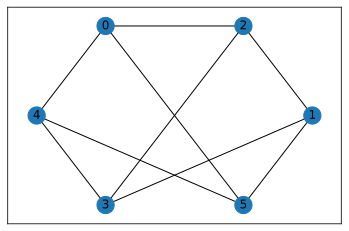

In [95]:
main()